<a href="https://colab.research.google.com/github/JNightshadow/testing/blob/main/driver_drowsiness_detection_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15247586389254675312
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1970680453526611214
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)


In [5]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Optional: Print device placement
tf.debugging.set_log_device_placement(True)

# Quick GPU test
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
print("Matrix product:\n", tf.matmul(a, b))


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
Matrix product:
 tf.Tensor([[11.]], shape=(1, 1), dtype=float32)


In [6]:
!pip install split-folders


In [8]:
import os
import zipfile

# Make a hidden .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move kaggle.json to the kaggle directory
!mv kaggle.json /root/.kaggle/kaggle.json

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [12]:
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd

Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown


In [7]:
import splitfolders
data_dir = r'D:\Edocuments\AIDA\S2\NNDL\Project\Dataset\Driver Drowsiness Dataset (DDD)'
output_dir = r'D:\Edocuments\AIDA\S2\NNDL\Project\splitted_Data'
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

ValueError: The provided input folder "D:\Edocuments\AIDA\S2\NNDL\Project\Dataset\Driver Drowsiness Dataset (DDD)" does not exists. Your relative path cannot be found from the current working directory "/content".

In [14]:
# Unzip
!unzip driver-drowsiness-dataset-ddd.zip -d drowsiness_dataset


import splitfolders

input_folder = 'drowsiness_dataset/Driver Drowsiness Dataset (DDD)'  # <- correct path after unzip
output_folder = 'splitted_data'

splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, 0.15, 0.05))


Streaming output truncated to the last 5000 lines.
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: drowsiness_dataset/Driver Drowsiness Dataset (DDD)/Non Drowsy/y009

Copying files: 41793 files [00:31, 1314.62 files/s]


In [ ]:
# train_dir = r'D:\Edocuments\AIDA\S2\NNDL\Project\splitted_Data\train'
# test_dir = r'D:\Edocuments\AIDA\S2\NNDL\Project\splitted_Data\test'
# val_dir = r'D:\Edocuments\AIDA\S2\NNDL\Project\splitted_Data\val'

In [15]:
train_dir = 'splitted_data/train'
test_dir = 'splitted_data/test'
val_dir = 'splitted_data/val'


In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


Pixels of the first image after Normalization: 

[[[0.95294124 0.8941177  0.7960785 ]
  [0.9450981  0.882353   0.78823537]
  [0.95294124 0.8941177  0.7960785 ]
  ...
  [0.2627451  0.19215688 0.1254902 ]
  [0.27058825 0.19215688 0.12156864]
  [0.3254902  0.24313727 0.15686275]]

 [[0.9490197  0.89019614 0.7960785 ]
  [0.9490197  0.89019614 0.79215693]
  [0.95294124 0.8941177  0.7960785 ]
  ...
  [0.21960786 0.15686275 0.08627451]
  [0.227451   0.14901961 0.07450981]
  [0.3019608  0.22352943 0.14117648]]

 [[0.9450981  0.8862746  0.79215693]
  [0.9450981  0.882353   0.78823537]
  [0.94117653 0.882353   0.78823537]
  ...
  [0.19607845 0.13725491 0.0627451 ]
  [0.19215688 0.11764707 0.04705883]
  [0.2392157  0.14901961 0.08235294]]

 ...

 [[0.6901961  0.5764706  0.4784314 ]
  [0.6784314  0.5647059  0.45882356]
  [0.67058825 0.5568628  0.454902  ]
  ...
  [0.8980393  0.80392164 0.7411765 ]
  [0.90196085 0.8117648  0.7490196 ]
  [0.882353   0.80392164 0.7411765 ]]

 [[0.654902   0.5372549  

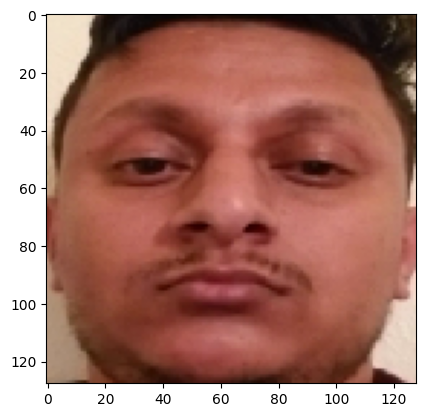

In [18]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[3]}")
plt.imshow(images[3])
plt.show()

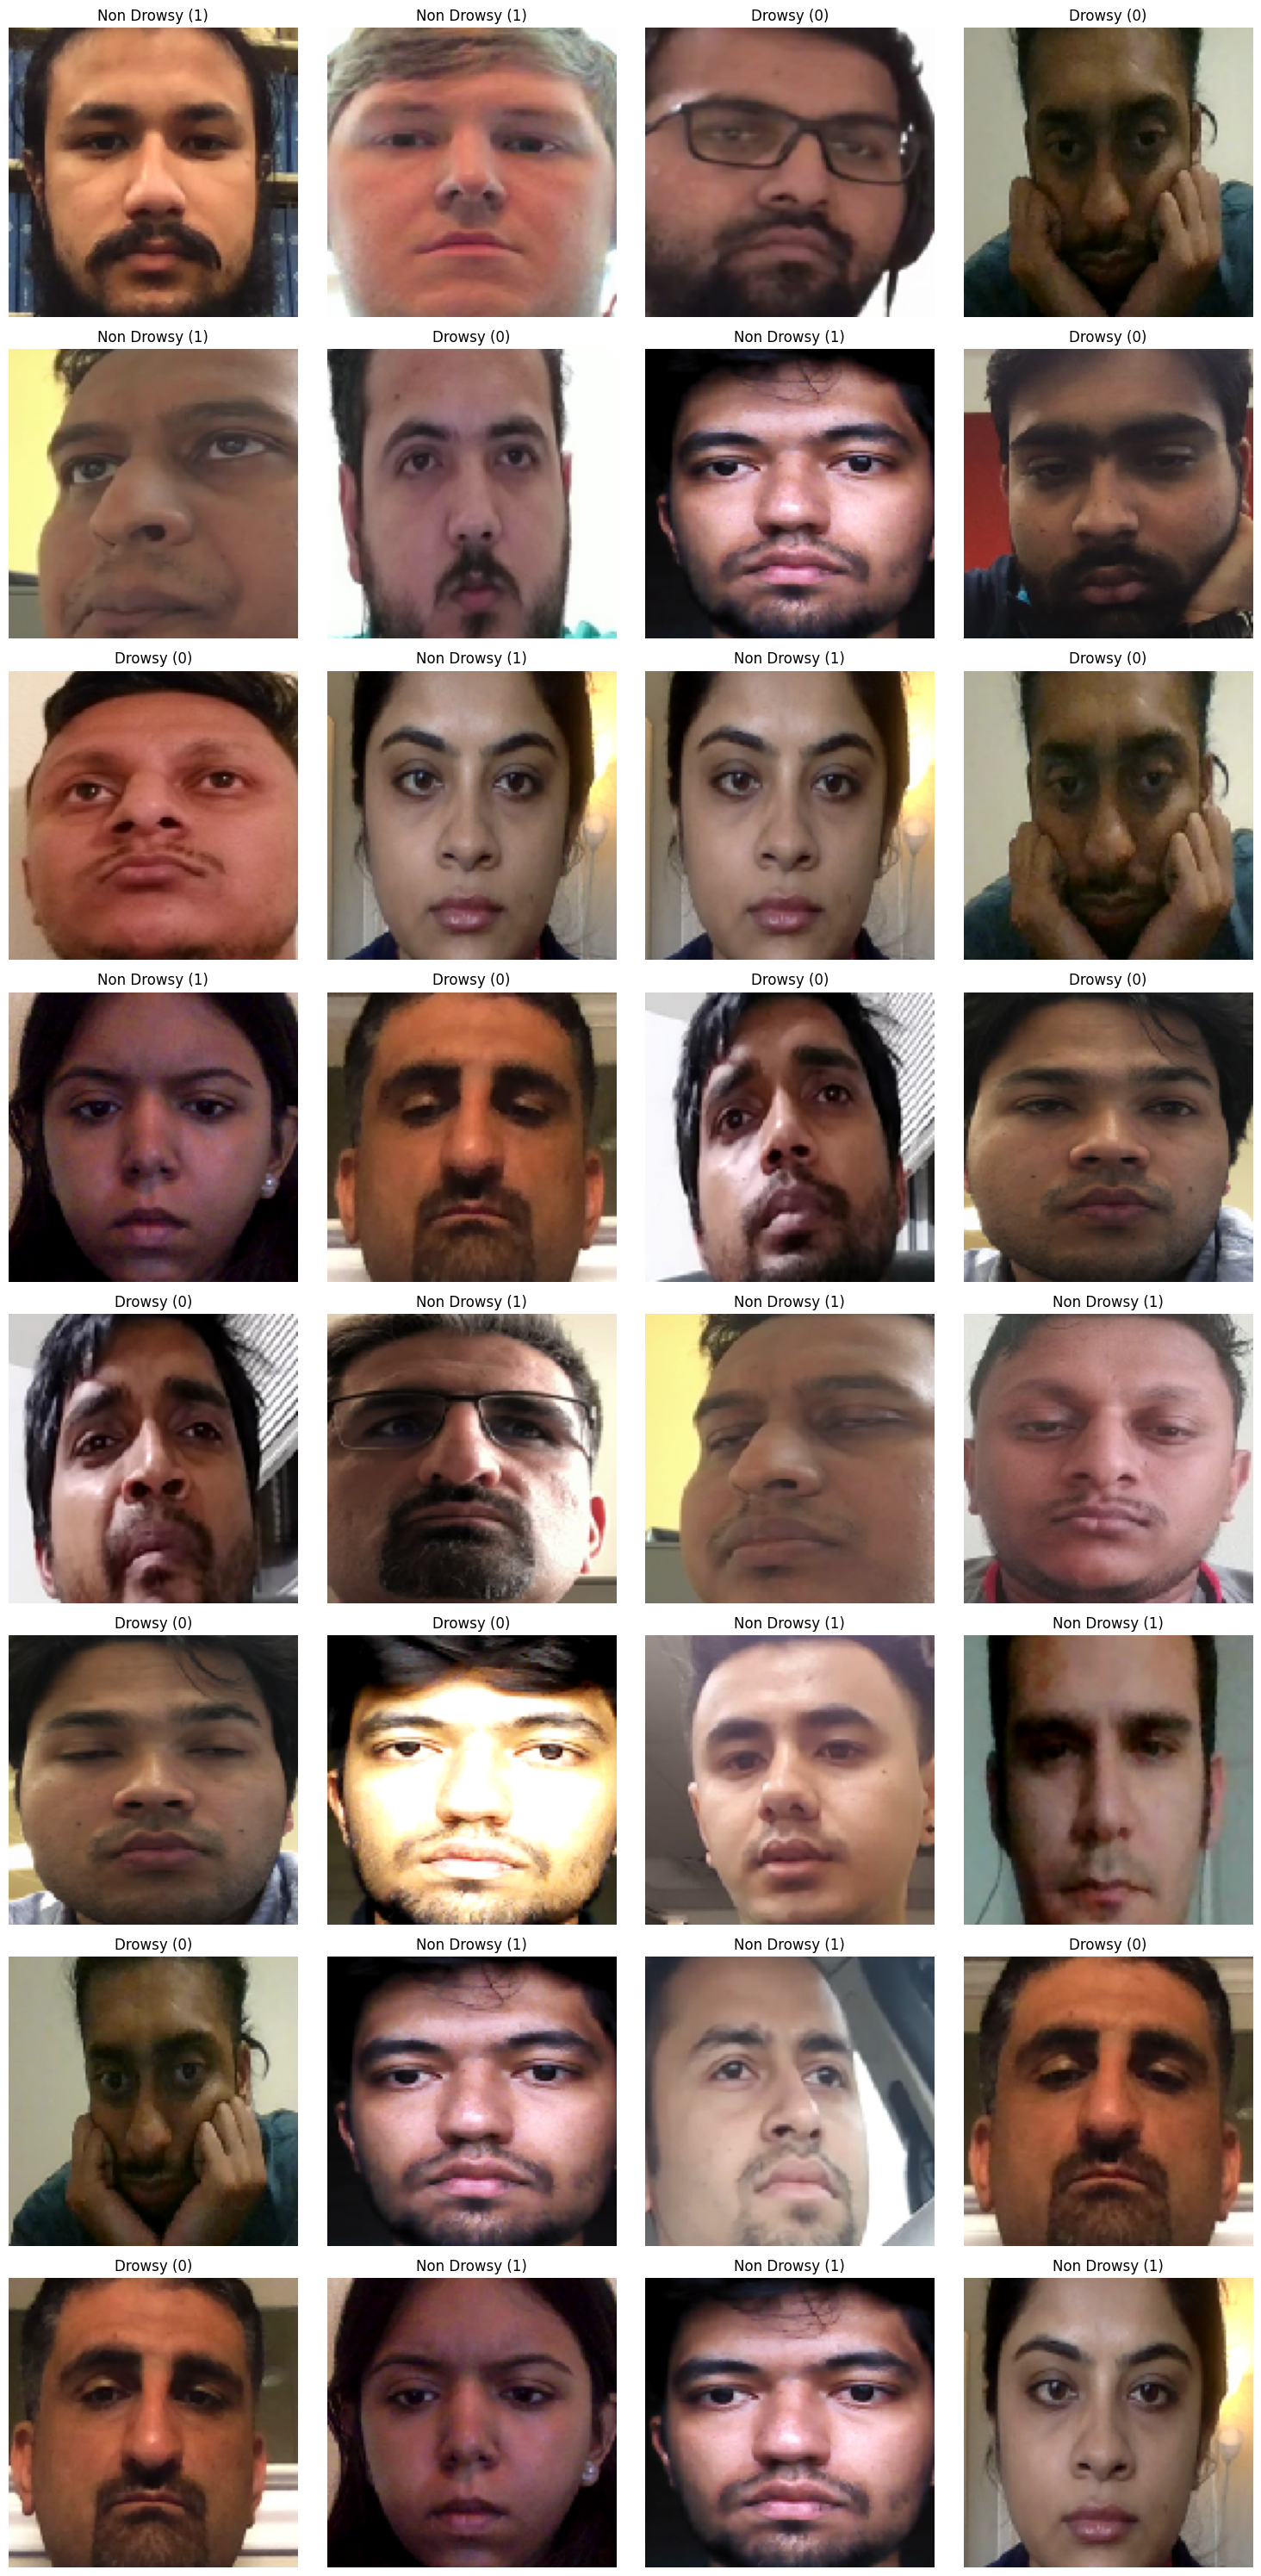

In [19]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):

        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [20]:
image_size = (128, 128)
sequence_length = 5

model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(16, return_sequences=False),
    Dropout(0.3),

    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 5, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 5, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,537 (37.25 KB)

 Trainable params: 9,425 (36.82 KB)

 Non-trainable params: 112 (448.00 B)

In [21]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []

        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)

        return np.array(X_seq), np.array(y_seq)

In [22]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=32)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=32)

In [23]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Streaming output truncated to the last 5000 lines.
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
33/65 ━━━━━━━━━━━━━━━━━━━━ 1:17 2s/step - accuracy: 0.8010 - loss: 0.4638Executing op __inference_multi_step_on_iterator_8523 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalHasValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptionalGetValue in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mean in device /job:localhost/replica:0/task:0/device:GPU

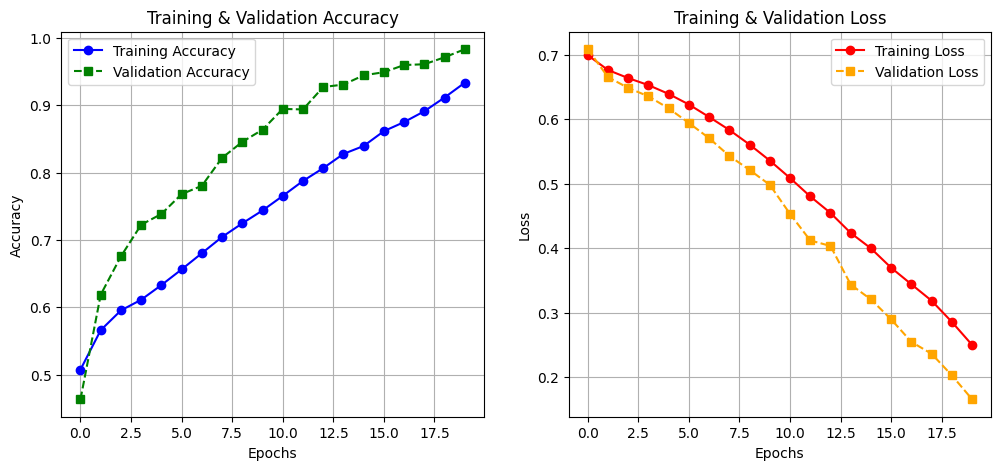

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy", color="blue", marker="o", linestyle="-")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color="green", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss", color="red", marker="o", linestyle="-")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="orange", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid(True)

plt.show()



In [34]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model

# Wrap your trained Sequential model into a Functional one
inputs = Input(shape=(5, 128, 128, 3))  # sequence_length, height, width, channels
outputs = model(inputs)
functional_model = Model(inputs, outputs)


In [37]:
model.save_weights("drowsy.weights.h5")


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

In [68]:
# Rebuild the functional model from the trained Sequential one
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Reconstruct Functional model
input_layer = Input(shape=(5, 128, 128, 3))
x = model(input_layer)
functional_model = Model(inputs=input_layer, outputs=x)
functional_model.set_weights(model.get_weights())  # Load trained weights

# Run dummy input to build it
dummy_input = np.random.rand(1, 5, 128, 128, 3).astype(np.float32)
_ = functional_model.predict(dummy_input)


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

In [69]:
def get_gradcam_heatmap(model, img_seq, last_conv_layer_name):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_seq)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [70]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Dropout, Dense

image_size = (128, 128)
sequence_length = 5

# Rebuild the full model using functional API
input_layer = Input(shape=(sequence_length, image_size[0], image_size[1], 3))

x = TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), name="conv1")(input_layer)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)

x = TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'), name="conv2")(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)

x = TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), name="conv3")(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)

x = TimeDistributed(GlobalAveragePooling2D(), name="gap")(x)
x = LSTM(16, return_sequences=False)(x)
x = Dropout(0.3)(x)

x = Dense(8, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
functional_model = Model(inputs=input_layer, outputs=output)
functional_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Load previously saved weights
functional_model.set_weights(model.get_weights())


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:loca

conv1
time_distributed_16
time_distributed_17
conv2
time_distributed_18
time_distributed_19
conv3
time_distributed_20
time_distributed_21
gap
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_40']]
Received: inputs=Tensor(shape=(1, 5, 128, 128, 3))
  warnings.warn(msg)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica

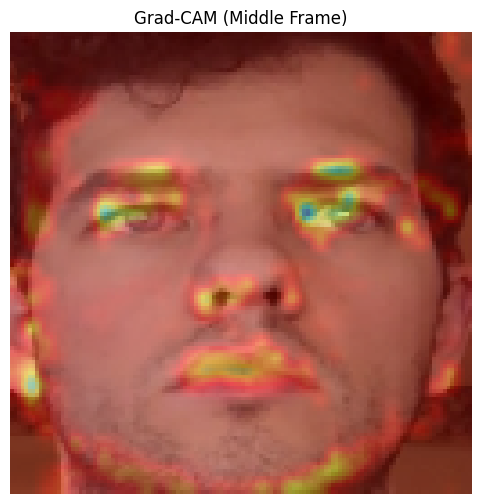

In [71]:
# Choose a validation sequence
sample_seq_batch, sample_label_batch = val_seq[0]  # first batch
sample_seq = sample_seq_batch[0]  # one sequence (5 frames)

middle_frame = sample_seq[2]  # pick middle frame
gradcam_input = np.expand_dims(sample_seq, axis=0)

# Find your last TimeDistributed Conv2D layer name
for layer in functional_model.layers:
    if isinstance(layer, tf.keras.layers.TimeDistributed):
        print(layer.name)

# Use the correct layer name (adjust if needed)
last_conv_layer_name = "conv3"  # ← update if different

# Generate heatmap
heatmap = get_gradcam_heatmap(functional_model, gradcam_input, last_conv_layer_name)

# Visualize Grad-CAM on middle frame
import cv2
heatmap_resized = cv2.resize(heatmap[2], (128, 128))  # middle frame
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

original_frame = (middle_frame * 255).astype(np.uint8)
superimposed_img = cv2.addWeighted(original_frame, 0.6, heatmap_colored, 0.4, 0)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(superimposed_img)
plt.axis('off')
plt.title("Grad-CAM (Middle Frame)")
plt.show()


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/

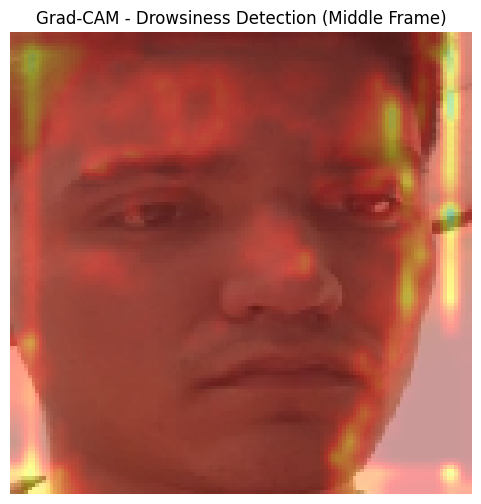

In [53]:
# Name of your last convolutional layer (now it's "conv3" based on your model)
last_conv_layer_name = "conv3"

# Generate Grad-CAM heatmap
heatmap = get_gradcam_heatmap(functional_model, gradcam_input, last_conv_layer_name)

# Visualize Grad-CAM on middle frame
heatmap_resized = cv2.resize(heatmap[2], (128, 128))  # heatmap[2] corresponds to middle frame
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Overlay on original image
original_frame = (middle_frame * 255).astype(np.uint8)
superimposed_img = cv2.addWeighted(original_frame, 0.6, heatmap_colored, 0.4, 0)

# Plot the result
plt.figure(figsize=(6, 6))
plt.imshow(superimposed_img)
plt.title("Grad-CAM - Drowsiness Detection (Middle Frame)")
plt.axis('off')
plt.show()


In [64]:
# Get the model's prediction for the sample sequence
predictions = functional_model.predict(gradcam_input)

# Print the prediction value
print(f"Prediction: {predictions}")

# Check if it's a binary classification and interpret the result
if predictions.shape[-1] == 1:
    predicted_class = (predictions > 0.5).astype("int32")
    print(f"Predicted class (0 or 1): {predicted_class}")
else:
    print("Prediction output is not binary. Make sure you're handling multi-class correctly.")


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

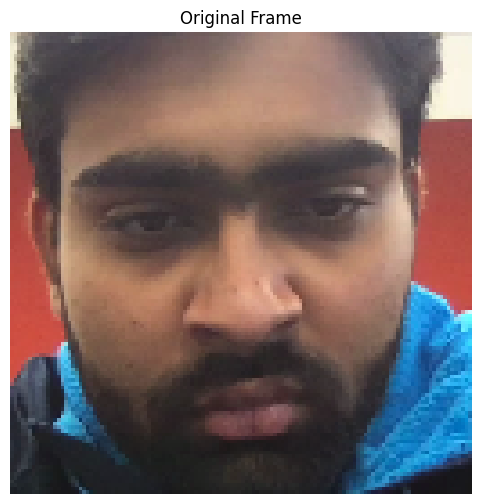

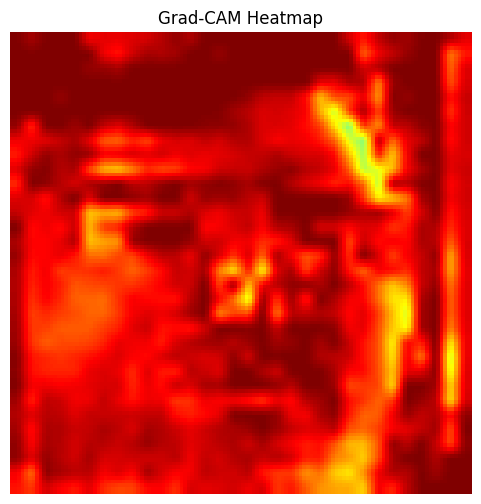

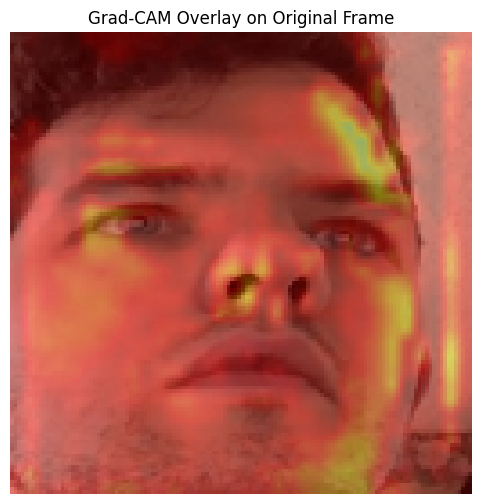

In [67]:
# Display the original frame (middle frame from the sequence)
plt.figure(figsize=(6, 6))
plt.imshow(original_frame)
plt.title("Original Frame")
plt.axis('off')
plt.show()

# Display the Grad-CAM heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_colored)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()

# Display the overlayed image (original frame + heatmap)
plt.figure(figsize=(6, 6))
plt.imshow(superimposed_img)
plt.title("Grad-CAM Overlay on Original Frame")
plt.axis('off')
plt.show()


In [48]:
# Assuming 'gradcam_input' is your input data
predictions = functional_model.predict(gradcam_input)

# Check if the prediction is greater than 0.5 (indicating class 1, Drowsy)
predicted_class = 1 if predictions > 0.5 else 0

# Print out the result
if predicted_class == 1:
    print("The driver is Drowsy (Class 1).")
else:
    print("The driver is Non-Drowsy (Class 0).")


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/

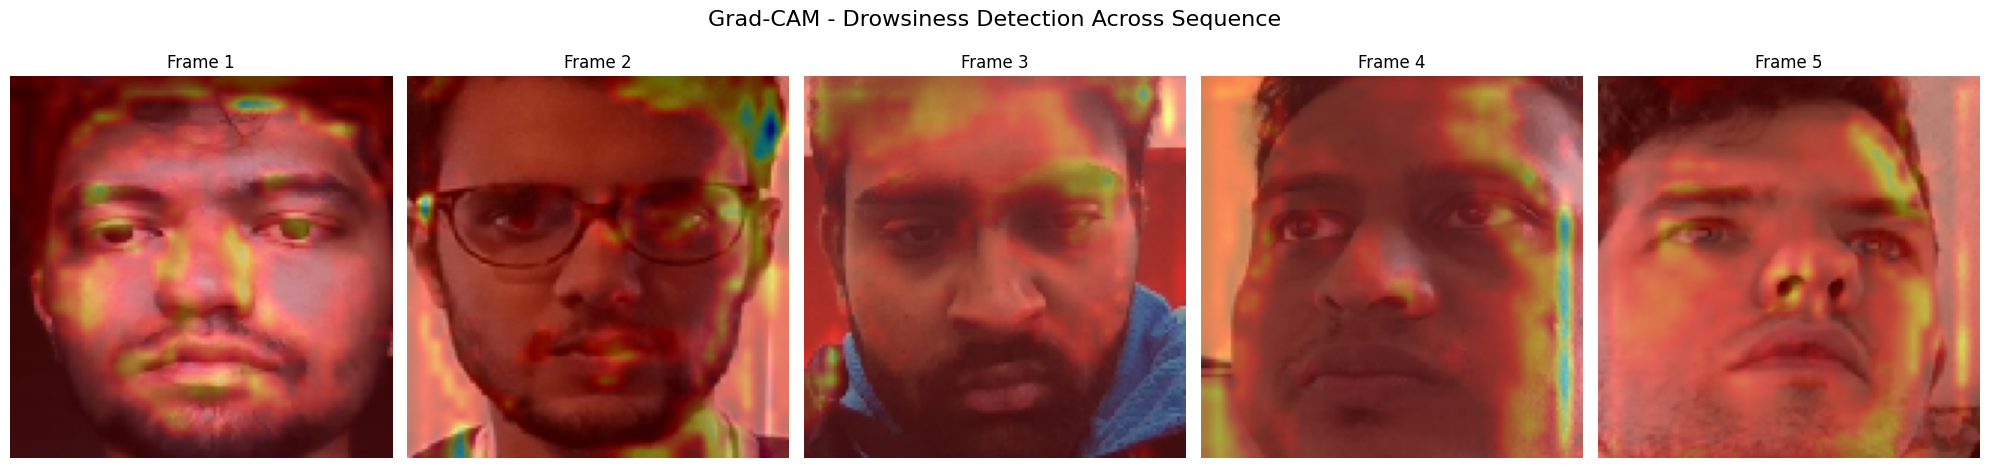

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Your settings
last_conv_layer_name = "conv3"  # as before
input_frames = (gradcam_input[0] * 255).astype(np.uint8)  # shape: (5, 128, 128, 3)

# Generate Grad-CAM heatmap for all frames
heatmap = get_gradcam_heatmap(functional_model, gradcam_input, last_conv_layer_name)  # shape: (5, H, W)

# Create a figure for side-by-side visualization
plt.figure(figsize=(20, 5))

for i in range(5):
    # Resize heatmap to match frame size
    heatmap_resized = cv2.resize(heatmap[i], (128, 128))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Original frame
    frame = input_frames[i]

    # Overlay heatmap
    superimposed_img = cv2.addWeighted(frame, 0.6, heatmap_colored, 0.4, 0)

    # Plot
    plt.subplot(1, 5, i + 1)
    plt.imshow(superimposed_img)
    plt.title(f"Frame {i+1}")
    plt.axis('off')

plt.suptitle("Grad-CAM - Drowsiness Detection Across Sequence", fontsize=16)
plt.tight_layout()
plt.show()
